# Exercises

We have four exercises in this section:
1. Rewrite the CART method to the Gini index.
2. Use pydot do draw the tree for C4.5 example.
3. Implement the minimum number of objects pruning method.
4. Plot OC1 tree, but instead of elements id, print the feature id it was split by.

## Exercise 1: Rewrite the CART method to use Gini index as shown in the lecture

Use Gini index can be calculated with the following equation:
\begin{equation}
I_{G}(X)=1-\sum_{i=1}^{m}p^{2}_{i},
\end{equation}
and
\begin{equation}
I_{G}(\text{feature})=\sum_{i=1}^{n}p_{i}*I_{G}(X_{i}).
\end{equation}

You need to fill the ``calculate_gini`` function and change the ``build`` function a bit.

In [131]:
import math
import numpy as np
import pydot
import copy

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root

## helper methods:

def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()

def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

def find_leaf_not_completed(root):
    return is_leaf_completed(root)


## CART methods:

def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list


def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count


def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()

def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count

def calculate_gini(elements, index):
    gini_sum = 0
    unique_labels = get_unique_labels(current_node.labels)
    one_count, minus_one_count, element_size, partial = [], [], [], []

    for element in elements:
        element_size.append(count_number_of_elements(element, index))
        one_count.append(get_number_of_labels_for_value(element, index, 1))
        minus_one_count.append(get_number_of_labels_for_value(element, index, - 1))
       
    for i in range(len(elements)):
        partial.append(1 - (one_count[i] / element_size[i]) ** 2 - (minus_one_count[i] / element_size[i]) ** 2)
        gini_sum += (partial[i] * element_size[i]) / (element_size[0] + element_size[1])
    
    return 1 - gini_sum

def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False

def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if len(right_leaf_labels) == 0 or len(left_leaf_labels) == 0:
        current_node.set_completed()
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    current_node.set_split(split_id)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    return current_node, split_history

def get_current_node():
    return find_leaf_not_completed()


def build(root_node):
    current_node = root_node
    stop_criterion = False
    split_history = []
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        max_unique_id = 0
        max_split_id = 0
        max_value = 0
        for i in range(len(unique_values)):  # co gdy len(unique) == 1 ?
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                current_value = calculate_gini(split_candidates[j], i)
                if max_value < current_value:
                    max_unique_id = i
                    max_split_id = j
                    max_value = current_value
        current_node, split_history = split_node(current_node, unique_values[max_unique_id][max_split_id], max_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('cart_tree.png', format='png')


cart_tree, split_history = build(current_node)
plot_tree(split_history)

## Exercise 2: Use pydot do draw the tree for C4.5 example

Fill the code below.

In [132]:
%store -r split_history_c45

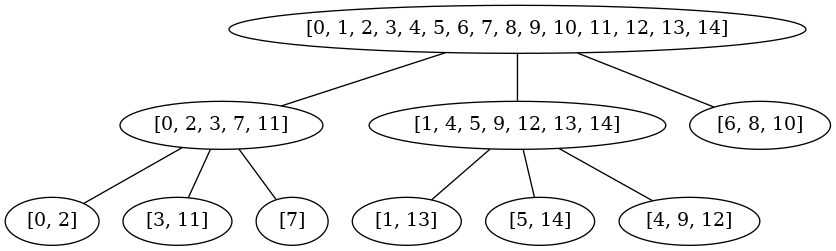

In [133]:
def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1])
        tree.add_edge(new_edge)
    tree.write('c45_tree.png', format='png')
    
plot_tree(split_history_c45)

from IPython.display import Image
Image(filename='c45_tree.png') 

## Exercise 3: Implement the minimum number of objects pruning method

The MNO method checkes the accuracy at each split and prune the node if the number of objects in a leaf is below a given value N. Load the CART method first as below.

In [134]:
import math
import numpy as np
import copy

N = 3

labels = [1,1,-1,1,-1,-1,1,1,1,1,1,1,-1,-1,-1]
data_set = [[1,1,2,2],[2,1,2,2],[1,1,1,2],[1,2,1,2],[2,3,2,2],
                [2,2,1,2],[3,2,2,1],[1,3,2,2],[3,3,2,1],[2,3,1,2],
                [3,1,1,1],[1,2,1,1],[2,3,1,1],[2,1,1,2],[2,2,1,1]]

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.elements = elements
        self.split_feature = None
        self.split_value = None
        self.labels = labels
        self.completed = False
        self.ids = ids
        self.validated = False

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels

    def set_split(self, feature):
        self.split_feature = feature

    def get_split(self):
        return self.split_feature

    def set_split_value(self, value):
        self.split_value = value

    def get_split_value(self):
        return self.split_value

    def set_validated(self):
        self.validated = True

    def is_validated(self):
        return self.validated

    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root


def get_unique_labels(labels):
    return np.unique(np.array(labels)).tolist()


def get_unique_values(elements):
    features_number = len(elements[0])
    unique = []
    for i in range(features_number):
        features_list = []
        for j in range(len(elements)):
            features_list.append(elements[j][i])
        unique.append(np.unique(np.array(features_list)))
    return unique


def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node


def find_leaf_not_completed(root):
    return is_leaf_completed(root)


def get_split_candidates(unique_values):
    split_list = []
    for i in range(len(unique_values)):
        current_list = []
        temp_list = copy.deepcopy(unique_values)
        current_list.append(temp_list[i])
        del temp_list[i]
        current_list.append(temp_list)
        split_list.append(current_list)
    return split_list


def get_number_of_labels_for_value(elements, column_id, label):
    count = 0
    if not isinstance(elements, list):
        elements_list = [elements]
    else:
        elements_list = elements

    column_elements = get_node_elements_column(column_id)

    for i in range(len(elements_list)):
        for j in range(len(column_elements)):
            if column_elements[j] == elements_list[i]:
                if current_node.labels[j] == label:
                    count = count + 1
    return count


def get_node_elements_column(column_id):
    return np.array(current_node.elements)[..., column_id].tolist()


def count_number_of_elements(elements, column_id):
    count = 0
    if isinstance(elements, list):
        column_elements = get_node_elements_column(column_id)
        for i in range(len(elements)):
            count = count + column_elements.count(elements[i])
    else:
        count = count + get_node_elements_column(column_id).count(elements)
    return count


def calculate_omega(elements, column_id):
    t_l = count_number_of_elements(elements[0], column_id)
    t_r = count_number_of_elements(elements[1], column_id)
    p_l = t_l * 1.0 / len(current_node.elements) * 1.0
    p_r = t_r * 1.0 / len(current_node.elements) * 1.0

    sum_p = 0
    labels = get_unique_labels(current_node.labels)
    for i in range(labels_count):
        p_class_t_l = (get_number_of_labels_for_value(elements[0], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[0], column_id) * 1.0)
        p_class_t_r = (get_number_of_labels_for_value(elements[1], column_id, labels[i]) * 1.0) / (
                count_number_of_elements(elements[1], column_id) * 1.0)
        sum_p = sum_p + math.fabs(p_class_t_l - p_class_t_r)
    return 2.0 * p_l * p_r * sum_p


def check_completed(labels, elements):
    ratio = len(get_unique_labels(labels))
    if ratio == 1:
        return True
    elements = sorted(elements)
    duplicated = [elements[i] for i in range(len(elements)) if i == 0 or elements[i] != elements[i - 1]]
    if len(duplicated) == 1:
        return True
    return False

def build(root_node):
    current_node = root_node
    stop_criterion = False
    split_history = []
    while stop_criterion == False:
        unique_values = get_unique_values(current_node.get_elements())
        max_unique_id = 0
        max_split_id = 0
        max_value = 0
        for i in range(len(unique_values)):
            if len(unique_values[i]) == 1:
                continue
            split_candidates = get_split_candidates(unique_values[i].tolist())
            for j in range(len(split_candidates)):
                current_value = calculate_omega(split_candidates[j], i)
                if max_value < current_value:
                    max_unique_id = i
                    max_split_id = j
                    max_value = current_value
        current_node, split_history = split_node(current_node, unique_values[max_unique_id][max_split_id],
                                                 max_unique_id, split_history)
        new_node = find_leaf_not_completed(root_node)
        if new_node != None:
            current_node = new_node
        else:
            stop_criterion = True
    return root_node, split_history

Fill the gap below:

In [135]:
def split_node(current_node, value, split_id, split_history):
    left_leaf = []
    left_leaf_labels = []
    left_leaf_ids = []
    right_leaf = []
    right_leaf_labels = []
    right_leaf_ids = []
    for i in range(len(current_node.elements)):
        if current_node.elements[i][split_id] == value:
            left_leaf.append(current_node.elements[i])            
            left_leaf_labels.append(current_node.labels[i])
            left_leaf_ids.append(current_node.ids[i])
        else:                   
            right_leaf.append(current_node.elements[i])
            right_leaf_labels.append(current_node.labels[i])
            right_leaf_ids.append(current_node.ids[i])
    if (len(left_leaf_labels) < N or len(right_leaf_labels) < N):
        current_node.set_completed()
        current_node.L = None
        current_node.R = None
        return current_node, split_history
    split_history.append([str(current_node.ids), str(left_leaf_ids)])
    split_history.append([str(current_node.ids), str(right_leaf_ids)])
    # change the code here:                
    current_node.set_L(BinaryLeaf(left_leaf, left_leaf_labels, left_leaf_ids))
    current_node.set_R(BinaryLeaf(right_leaf, right_leaf_labels, right_leaf_ids))
    current_node.set_split(split_id)
    current_node.set_completed()
    if check_completed(left_leaf_labels, left_leaf):
        current_node.L.set_completed()
    if check_completed(right_leaf_labels, right_leaf):
        current_node.R.set_completed()
    ####        
    return current_node, split_history

Test:

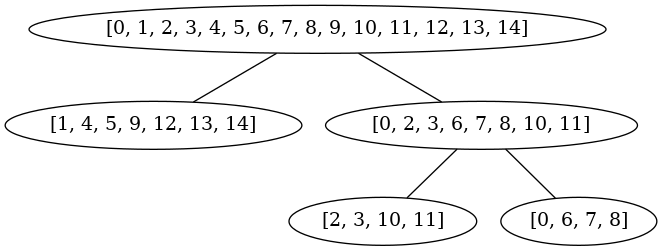

In [136]:
from IPython.display import Image

cart_tree, split_history_cart = build(current_node)

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        new_edge = pydot.Edge(split[0], split[1])
        tree.add_edge(new_edge)
    tree.write('pruned_tree.png', format='png')
    
plot_tree(split_history_cart)
Image(filename='pruned_tree.png')

## Exercise 4: Plot OC1 tree, but instead of elements id, print the feature id it was split by

To make the task done, you need to change the functions:
- ``build_level``,
- update the ``BinaryLeaf`` in two places to add the setters/getters and the feature and feature value split data.


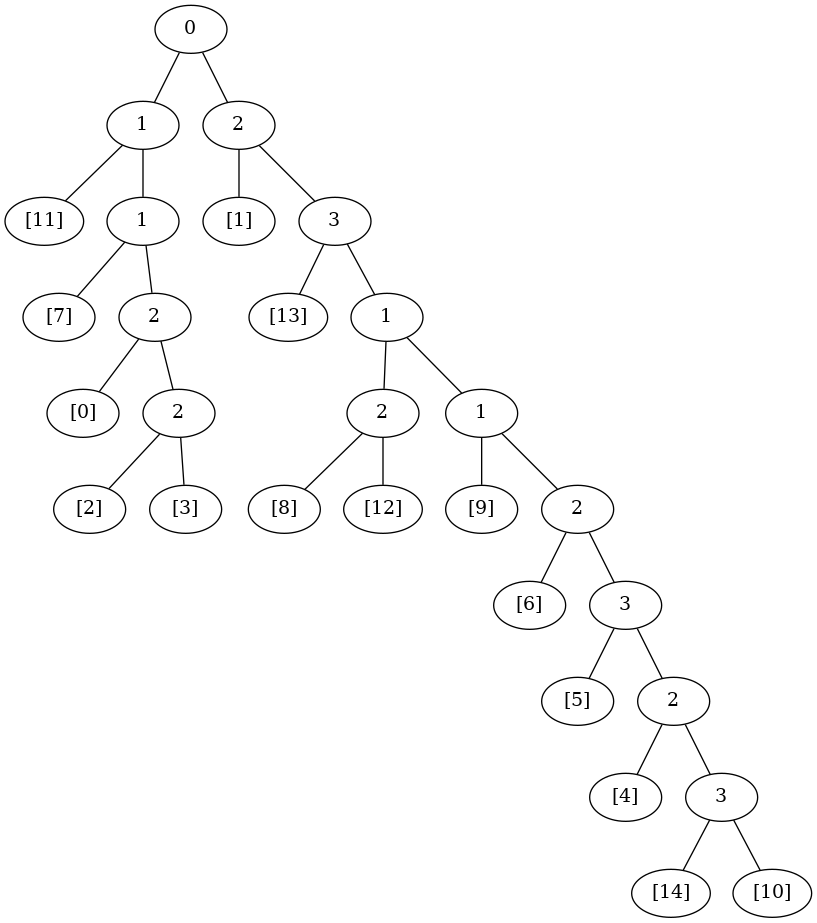

In [137]:
from IPython.display import Image
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

class BinaryLeaf:

    def __init__(self, elements, labels, ids):
        self.L = None
        self.R = None
        self.p = None
        self.elements = elements
        self.labels = labels
        self.completed = False
        self.ids = ids

    def set_R(self, Rleaf):
        self.R = Rleaf

    def set_L(self, Lleaf):
        self.L = Lleaf

    def set_elements(self, elements):
        self.elements = elements

    def get_elements(self):
        return self.elements

    def set_p(self, threshold):
        self.p = threshold

    def get_L(self):
        return self.L

    def get_R(self):
        return self.R

    def set_completed(self):
        self.completed = True

    def is_completed(self):
        return self.completed

    def get_labels(self):
        return self.labels
        
    def get_split_feature_id(self):
        return split_feature_id
        
    def set_ids(self, ids):
        self.ids = ids

    def get_ids(self):
        return self.ids

labels = [1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1]
data_set = [[1, 1, 2, 2], [2, 1, 2, 2], [1, 1, 1, 2], [1, 2, 1, 2], [2, 3, 2, 2],
            [2, 2, 1, 2], [3, 2, 2, 1], [1, 3, 2, 2], [3, 3, 2, 1], [2, 3, 1, 2],
            [3, 1, 1, 1], [1, 2, 1, 1], [2, 3, 1, 1], [2, 1, 1, 2], [2, 2, 1, 1]]


labels_count = len(np.unique(labels))

ids = list(range(len(data_set)))
root = BinaryLeaf(data_set, labels, ids)
current_node = root
R = 10

## helper methods:

def compute_v(element, scv):
    return np.sum(np.multiply(element, scv[:-1])) + scv[-1]

def compare_two_leafs(leaf1, leaf2):
    labels1 = leaf1.labels
    labels2 = leaf2.labels
    if len(labels1) == len(labels2):
        for i in range(len(labels1)):
            if labels1[i] != labels2[i]:
                return False
        return True
    return False

def is_leaf_completed(node):
    if node.is_completed():
        if node.get_L() != None and not node.get_L().is_completed():
            return node.get_L()
        elif node.get_R() != None and not node.get_R().is_completed():
            return node.get_R()
        elif node.get_L() == None and node.get_R() == None:
            return None
        elif node.get_L().is_completed() or node.get_R().is_completed():
            new_node = is_leaf_completed(node.get_L())
            if new_node == None:
                return is_leaf_completed(node.get_R())
            else:
                return new_node
        else:
            return None
    return node

## oc1

def calculate_gini(labels):
    unique_labels = np.unique(labels)
    gini = 0
    for label in unique_labels:
        found = np.where(labels == label)
        gini = gini + len(found)/len(labels)
    return np.square(gini)

def get_all_possible_splits_by_gini(leaf):
    leaf_elements = leaf.elements
    labels = leaf.labels
    ginis = []
    for i in range(len(leaf_elements[0])):
        feature_ginis = []
        feature_column = np.array(leaf_elements)[:, i]
        for feature in feature_column:
            distinguish = feature_column <= feature
            left_labels  = np.array(labels)[distinguish]
            right_labels = np.array(labels)[~distinguish]
            gini = 1 - calculate_gini(left_labels) - calculate_gini(right_labels)
            feature_ginis.append([feature,gini])
        ginis.append(min(feature_ginis))
    return ginis


def find_current_level_data(root):
    return is_leaf_completed(root)

def divide_data_hiperplane(leaf,scv):
    below = []
    above = []
    below_labels = []
    above_labels = []
    below_ids = []
    above_ids = []
    for i in range(len(leaf.elements)):
        v = compute_v(leaf.elements[i],scv) > 0
        if v:
            above.append(leaf.elements[i])
            above_labels.append(leaf.labels[i])
            above_ids.append(leaf.ids[i])            
        else:
            below.append(leaf.elements[i])
            below_labels.append(leaf.labels[i])
            below_ids.append(leaf.ids[i])    
    return np.array(below), np.array(above), np.array(below_labels), np.array(above_labels), below_ids, above_ids

def get_coefficiency(splits):
    splits = np.array(splits)
    scv = np.zeros(len(splits)+1)
    min_split_index = np.argmin(splits[:,1])
    scv[min_split_index] = 1
    scv[-1] = -splits[min_split_index][1]
    return scv

def compute_u(element, scv, feature):
    return (scv[feature] * element[feature] - compute_v(element, scv)) / element[feature]

def sort_u(element):
    return np.sort(element)

def perturb(leaf, scv, feature, old_gini):
    u=[]
    for element in leaf.elements:
        u.append(compute_u(element, scv, feature))
    splits = sort_u(np.array(u))
    am = []
    for split in splits:
        new_scv = scv
        new_scv[feature] = split
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf, scv)
        gini = 1 - (calculate_gini(below_label) - calculate_gini(above_label))
        am.append([new_scv, gini])
    am = np.array(am)
    best_split_index = np.argmin(am[:,1])
    if am[best_split_index][1] < old_gini:
        return am[best_split_index][1], am[best_split_index][0]
    elif am[best_split_index][1] == old_gini:
        if random() < 0.3:
            return am[best_split_index][1], am[best_split_index][0]
    return old_gini, scv


def build_level(root, split_history):
    leaf = find_current_level_data(root)
    if leaf == None:
        return
    splits = get_all_possible_splits_by_gini(leaf)
    split_coefficiency_vector = get_coefficiency(splits)
    below,above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    gini = 1 - calculate_gini(below_label) - calculate_gini(above_label)
    for c in range(R):
        feature = randint(0, len(leaf.elements[0]) - 1)
        if c == 0:
            split_feature = feature
        _gini, split_coefficiency_vector = perturb(leaf, split_coefficiency_vector, feature, gini)
        if _gini > gini:
            split_feature = feature
        gini = _gini
        below, above, below_label, above_label, below_ids, above_ids = divide_data_hiperplane(leaf,split_coefficiency_vector)
    left_leaf = BinaryLeaf(below, below_label, below_ids)
    right_leaf = BinaryLeaf(above, above_label, above_ids)
    split_history.append([str(leaf.ids), str(left_leaf.ids), str(split_feature)])
    split_history.append([str(leaf.ids), str(right_leaf.ids), str(split_feature)])
    leaf.set_completed()
    if len(np.unique(below_label)) == 1:
        left_leaf.set_completed()
    if len(np.unique(above_label)) == 1:
        right_leaf.set_completed()
    if compare_two_leafs(leaf, left_leaf) or compare_two_leafs(leaf,right_leaf):
        leaf.set_completed()
    else:
        leaf.set_R(right_leaf)
        leaf.set_L(left_leaf)
    build_level(root, split_history)
    return root, split_history

def build(root):
    split_history = []
    return build_level(root, split_history)

def plot_tree(split_history):
    tree = pydot.Dot(graph_type='graph')
    for split in split_history:
        tree.add_node(pydot.Node(split[0], label=split[2]))
        new_edge = pydot.Edge(split[0], split[1], fillcolor = 'red')
        tree.add_edge(new_edge)
    tree.write('oc1_tree.png', format='png')

oc1_tree, split_history = build(root)
plot_tree(split_history)
Image(filename='oc1_tree.png') 